In [1]:
import numpy as np
import pandas as pd

In [2]:
% pylab inline
% load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [3]:
%%R
#install.packages("pROC")
library(pROC)
library(arm)

/home/byang/anaconda2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Type 'citation("pROC")' for a citation.

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/byang/anaconda2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘pROC’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/byang/anaconda2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    cov, smooth, var


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/byang/anaconda2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: MASS

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/byang/anaconda2/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **ne

In [4]:
def gen_data(win_rate,
                oppty_growth_rate,
                cold_start_period,
                followon_periods,
                num_leads):
 
 
    mean_arrivals = np.zeros(cold_start_period).tolist() + [oppty_growth_rate**x for x in range(followon_periods)]
    actual_arrivals = [np.random.poisson(lam=x) for x in mean_arrivals]
 
    opptys = []
 
    for month,month_arrivals in enumerate(actual_arrivals):
        for a in range(month_arrivals):
            opptys.append((month,1 if np.random.random() < win_rate else 0))
 
    offered_leads = pd.DataFrame(opptys,columns=['MONTH','PURCH'])
 
    nans = [np.NAN for i in range(num_leads - len(offered_leads))]
    unoffered_leads = pd.DataFrame({'MONTH':nans,'PURCH':nans})
 
    leads = pd.concat({'o':offered_leads,'u':unoffered_leads}).reset_index()
 
    leads['CUST_ID'] = range(1,len(leads)+1)
 
    msk = np.random.rand(len(leads)) < win_rate
 
    leads['EVENTUAL_PURCH'] = np.where(leads.PURCH == 1,1,np.where(leads.PURCH == 0,0, np.where(msk,1,0)))
 
    leads['LOG_X1'] = leads.EVENTUAL_PURCH.map(lambda x: np.random.normal(.5,1.5) if x == 0 else np.random.normal(1.5,0.5))
 
    leads['X1'] = 10**leads['LOG_X1']
    leads['X2'] = [10**np.random.normal(1,1) for i in range(len(leads))]
    leads['X3'] = [10**np.random.standard_t(10) for i in range(len(leads))]
    leads['X4'] = [10**np.random.standard_t(10) for i in range(len(leads))] 
 
    return leads

In [5]:
from sklearn import metrics
 
def roc(yhat,y):
    fpr, tpr, thresholds = metrics.roc_curve(y, yhat)
    auc=metrics.auc(fpr, tpr)
    return auc
 
 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
 
def freq_log_reg(train,test,FEATURES):
    result = lr.fit(np.log10(train[FEATURES]), train['PURCH'])
    #print 'Freq Coefs',result.coef_
    test['score'] = lr.predict_proba(test[FEATURES])[:,1]
    return roc(test.score,test.EVENTUAL_PURCH)
 
def expert_model(train,test,FEATURES):
    test['score'] = 0
    for f in FEATURES:
        test['score'] += -1*np.log10(test[f])
    return roc(test.score,test.EVENTUAL_PURCH)
 
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
 
def gradient_boost(train,test,FEATURES):
    result = gb.fit(log10(train[FEATURES]), train['PURCH'])
    test['score'] = gb.predict_proba(test[FEATURES])[:,1]
    return roc(test.score,test.EVENTUAL_PURCH)

In [6]:
import pymc3 as pm
import scipy.stats as stats
 
def bayes_log_reg(train,test,FEATURES):
 
    niter = 1000
    LOG_FEATURES = ['LOG_' + f for f in FEATURES]
 
    for f in FEATURES:
        train['LOG_' + f] = np.log10(train[f])
        test['LOG_' + f] = np.log10(test[f])
 
    with pm.Model() as model:
 
        priors = {}
        for f in LOG_FEATURES:
            priors[f] = pm.distributions.Normal.dist(mu=-1, sd=0.5)
 
        pm.glm.glm('PURCH ~ ' + ' + '.join(LOG_FEATURES), train,family=pm.glm.families.Binomial(),priors=priors)
 
        #This seems slow
        #start = pm.find_MAP()
        #step = pm.NUTS(scaling=start)
 
        step = pm.Metropolis()
 
        trace = pm.sample(niter, step=step,progressbar=False)
        df_trace = pm.trace_to_dataframe(trace)
 
        test['score'] = 0
        coefs = []
        for f in LOG_FEATURES:
            b = df_trace[f].median()
            test['score'] += b*test[f]
            coefs.append(b)
        #print '\nBayes Coefs',coefs
 
    return roc(test.score,test.EVENTUAL_PURCH)

In [7]:
def eval(month,model,train,FEATURES):
    msk = train.MONTH <= month
    local_train = train[msk].copy(True)
    local_test = train[~msk].copy(True)
 
    if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
        return 0.5
 
    auc = model(local_train,local_test,FEATURES)
 
    return auc

In [8]:
win_rate = 0.4
oppty_growth_rate = 1.25
cold_start_period = 1
followon_periods = 30
num_leads = 10000
months = range(cold_start_period + followon_periods)

leads_list=[]
for i in range(10):
    leads_list.append(gen_data(win_rate,oppty_growth_rate,cold_start_period,followon_periods,num_leads))

In [10]:
%Rpush leads_list

In [11]:
%%R
a <- leads_list[,1]
df <- data.frame(matrix(unlist(a), nrow=10000, byrow=F),stringsAsFactors=FALSE)
head(df)

  X1 X2 X3 X4 X5 X6       X7       X8         X9         X10         X11
1  1  0  1  1  1  1 1.694364 49.47256  0.3497934   0.1841003   0.1694997
2  1  1  1  1  2  1 1.546368 35.18581  9.3707095   0.4564057 867.3986391
3  1  2  3  1  3  1 1.978895 95.25663  9.0539664 194.3910879   0.0359426
4  1  3  4  0  4  0 1.150671 14.14722 18.9726902 141.1086375  24.6424481
5  1  4  4  1  5  1 1.618927 41.58409  3.9472847   0.7248596   2.2204062
6  1  5  4  1  6  1 1.635002 43.15208 50.4278396  76.8953324   7.0459218


In [12]:
%%R
leads_sim <-  vector("list", 10)
for (i in 1:10){
    a <- leads_list[,i]
    leads_sim[[i]] <- data.frame(matrix(unlist(a), nrow=10000, byrow=F),stringsAsFactors=FALSE)   
    colnames(leads_sim[[i]]) <- c("level_0", "level_1",'MONTH','PURCH','CUST_ID','EVENTUAL_PURCH','LOG_X1','X1','X2','X3',"X4")
}
#head(df)

In [13]:
%%R
head(leads_sim[[10]])

  level_0 level_1 MONTH PURCH CUST_ID EVENTUAL_PURCH     LOG_X1          X1
1       1       0     1     0       1              0 -0.4436482   0.3600409
2       1       1     2     0       2              0  2.0733870 118.4096189
3       1       2     3     1       3              1  1.0439658  11.0653666
4       1       3     3     1       4              1  1.6870327  48.6443863
5       1       4     4     0       5              0 -0.9184043   0.1206690
6       1       5     4     0       6              0  1.5311186  33.9718009
         X2           X3           X4
1 16.664820 1.557198e-02 4.257127e+02
2  4.277231 4.830526e-01 1.380364e+00
3 28.738166 2.034138e-01 6.062246e-03
4  5.227176 1.486484e+00 1.843100e-01
5  3.096421 1.683286e+01 3.802802e+01
6 11.320315 9.685309e-04 3.605994e-03


In [15]:
%%R
for (i in 1:10){
    leads_sim[[i]] <- as.data.frame(as.matrix(leads_sim[[i]]))
    leads_sim[[i]]$LOG_X1 <- as.numeric(leads_sim[[i]]$LOG_X1)
    leads_sim[[i]]$X2 <- as.numeric(leads_sim[[i]]$X2)
    leads_sim[[i]]$X3 <- as.numeric(leads_sim[[i]]$X3)
    leads_sim[[i]]$X4 <- as.numeric(leads_sim[[i]]$X4)
    leads_sim[[i]]$MONTH <- as.numeric(leads_sim[[i]]$MONTH)
    leads_sim[[i]]$LOG_X2 <- log10(leads_sim[[i]]$X2)
    leads_sim[[i]]$LOG_X3 <- log10(leads_sim[[i]]$X3)
    leads_sim[[i]]$LOG_X4 <- log10(leads_sim[[i]]$X4)
    unique(leads_sim[[i]]$EVENTUAL_PURCH)    
}


In [16]:
%%R
bayesscale<- function(myVar){
  zVar <-0.5* (myVar - mean(myVar)) / sd(myVar)
  return(zVar)
}
#base
for (i in 1:10){
    base <- leads_sim[[i]][c('LOG_X1','LOG_X2','LOG_X3','LOG_X4')]
    base_s <- apply(base,2,bayesscale)
    base_s <- data.frame(base_s)
    colnames(base_s) <- c("X1s", "X2s",'X3s','X4s')
    head(base_s)
    leads_sim[[i]] <- cbind(leads_sim[[i]],base_s)
    #head(leads)    
}


In [17]:
%%R
eva_bayes <- function(month,train,scale){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test <-  train[!msk,]
    na_msk <- is.na(local_train$PURCH)
    local_train <- local_train[!na_msk,]
    
    if (dim(local_train)[1]==0) {
        auc <- 0.5
    } 
    else {
    model <- bayesglm(formula = PURCH ~ X1s+X2s+X3s+X4s, family = "binomial", data = local_train, 
                maxit=1000,prior.mean=1,prior.scale=scale, prior.df=1)
    predicted <- predict(model, local_test, type="response")   
    #if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
    #return 0.5 
    auc <- auc(local_test$EVENTUAL_PURCH, predicted)        
    }    
    return(auc)    
}

In [18]:
%%R
eva_expert <- function(month,train){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test = train[!msk,]

    local_test$predicted <- local_test$X1s+local_test$X2s+local_test$X3s+local_test$X4s
    #if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
    #return 0.5 
    auc <- auc(local_test$EVENTUAL_PURCH, local_test$predicted)
    return(auc)    
}

In [19]:
%%R
eva_gaussian <- function(month,train){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test <-  train[!msk,]
    na_msk <- is.na(local_train$PURCH)
    local_train <- local_train[!na_msk,]
    
    if (dim(local_train)[1]==0) {
        auc <- 0.5
    } 
    else {
    model <- bayesglm(formula = PURCH ~ X1s+X2s+X3s+X4s, family = "binomial", data = local_train, 
                maxit=1000,prior.mean=1,prior.scale=2.5, prior.df=Inf)
    predicted <- predict(model, local_test, type="response")   
    #if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
    #return 0.5 
    auc <- auc(local_test$EVENTUAL_PURCH, predicted)        
    }    
    return(auc)    
}

In [20]:
%%R
eva_frequentist <- function(month,train){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test = train[!msk,]
    na_msk <- is.na(local_train$PURCH)
    local_train <- local_train[!na_msk,]    
    if (dim(local_train)[1]==0) {
        auc <- 0.5
    } 
    else {
    model <- glm(formula = PURCH ~ X1s+X2s+X3s+X4s, family = "binomial", data = local_train)
    predicted <- predict(model, local_test, type="response")   
    
    auc <- auc(local_test$EVENTUAL_PURCH, predicted)
    }
    return(auc)    
}

In [21]:
%%R
auc_1 <- rep(0,31)
auc_2 <- rep(0,31)
auc_3 <- rep(0,31)
auc_expert <- rep(0,31)
auc_frequentist <- rep(0,31)
for (m in 1:31){
    auc_1[m] <- eva_bayes(m,leads_sim[[10]],0.1)
    auc_2[m] <- eva_bayes(m,leads_sim[[10]],2.5)
    auc_3[m] <- eva_bayes(m,leads_sim[[10]],5)
    auc_expert[m] <- eva_expert(m,leads_sim[[10]])
    auc_frequentist[m] <- eva_frequentist(m,leads_sim[[10]])
}

In [22]:
%%R
eva_bayes(1,leads_sim[[10]],0.1)

[1] 0.5


In [23]:
%%R
auc_1 <- rep(0,31)

for (m in 1:31){
     eva_bayes(m,leads_sim[[10]],0.1)

}

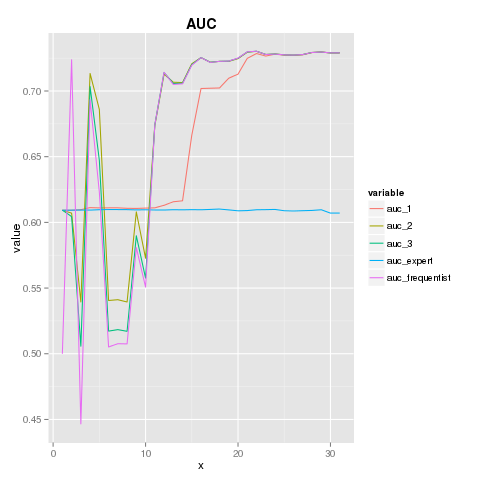

In [22]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_1,auc_2,auc_3,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

In [23]:
%%R
auc_1 <- vector("list", 10)
auc_2 <- vector("list", 10)
auc_3 <- vector("list", 10)
auc_expert<- vector("list", 10)
auc_frequentist<- vector("list", 10)
auc_gaussian<- vector("list", 10)
for (i in 1:10){
    print(i)
    auc_1[[i]] <- rep(0,31)
    auc_2[[i]] <- rep(0,31)
    auc_3[[i]] <- rep(0,31)
    auc_expert[[i]] <- rep(0,31)
    auc_frequentist[[i]] <- rep(0,31)
    auc_gaussian[[i]] <- rep(0,31)
    for (m in 1:31){
        auc_1[[i]][m] <- eva_bayes(m,leads_sim[[i]],0.1)
        auc_2[[i]][m] <- eva_bayes(m,leads_sim[[i]],2.5)
        auc_3[[i]][m] <- eva_bayes(m,leads_sim[[i]],5)
        auc_expert[[i]][m] <- eva_expert(m,leads_sim[[i]])
        auc_frequentist[[i]][m] <- eva_frequentist(m,leads_sim[[i]])
        auc_gaussian[[i]][m] <- eva_gaussian(m,leads_sim[[i]])
    }    
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


In [25]:
%%R
save(auc_1,auc_2,auc_3,auc_expert,auc_frequentist,auc_gaussian, file = "sim_data2.RData")

In [26]:
%%R
load("sim_data2.RData")

In [24]:
%%R
auc_1[[1]]

 [1] 0.6064196 0.6064196 0.6059132 0.6105382 0.6085656 0.6081201 0.6095922
 [8] 0.6113066 0.6109873 0.6103508 0.6126900 0.6162956 0.6224022 0.6276452
[15] 0.7148221 0.7054149 0.7104489 0.7198373 0.7269852 0.7289269 0.7291360
[22] 0.7305367 0.7293084 0.7297902 0.7289293 0.7299351 0.7313256 0.7308332
[29] 0.7294534 0.7290124 0.7290124


In [27]:
%Rpull auc_1

In [28]:
%Rpull auc_2

In [29]:
%Rpull auc_3

In [30]:
%Rpull auc_expert

In [31]:
%Rpull auc_frequentist

In [32]:
%Rpull auc_gaussian

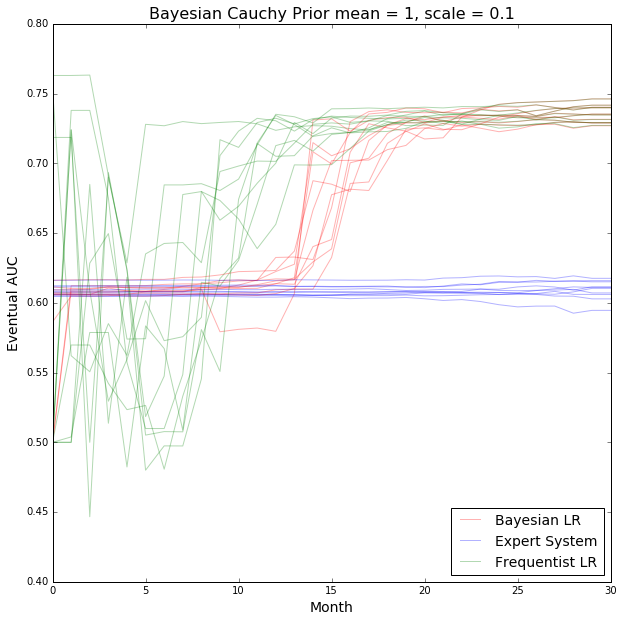

In [34]:
fig, ax = plt.subplots()
for s in range(10):
    bayes_label = None
    expert_label = None
    frequentist_label = None
    if s == 0:
        bayes_label = 'Bayesian LR'
        expert_label = 'Expert System'
        frequentist_label = 'Frequentist LR'
            
    plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    plot(auc_expert[s],color='blue',alpha=0.3,label=expert_label)
    plot(auc_frequentist[s],color='green',alpha=0.3,label=frequentist_label)
    #plot(auc_gaussian[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)

    plt.legend(loc="lower right",fontsize=14)


    ax.set_ylabel("Eventual AUC",fontsize=14)
    ax.set_xlabel("Month",fontsize=14)
    
    plt.title('Bayesian Cauchy Prior mean = 1, scale = 0.1',fontsize=16)
    
    plt.gcf().set_size_inches(10, 10);


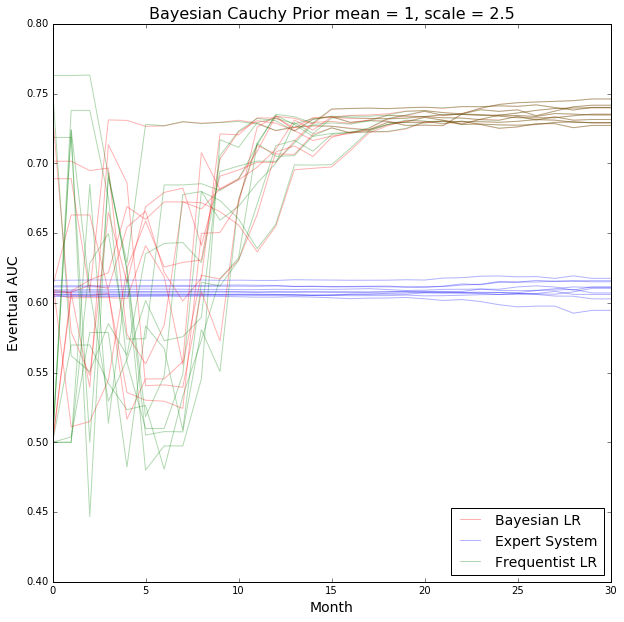

In [35]:
fig, ax = plt.subplots()
for s in range(10):
    bayes_label = None
    expert_label = None
    frequentist_label = None
    if s == 0:
        bayes_label = 'Bayesian LR'
        expert_label = 'Expert System'
        frequentist_label = 'Frequentist LR'
            
    plot(auc_2[s],color='red',alpha=0.3,label=bayes_label)
    plot(auc_expert[s],color='blue',alpha=0.3,label=expert_label)
    plot(auc_frequentist[s],color='green',alpha=0.3,label=frequentist_label)
    #plot(auc_gaussian[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)

    plt.legend(loc="lower right",fontsize=14)


    ax.set_ylabel("Eventual AUC",fontsize=14)
    ax.set_xlabel("Month",fontsize=14)
    
    plt.title('Bayesian Cauchy Prior mean = 1, scale = 2.5',fontsize=16)
    
    plt.gcf().set_size_inches(10, 10);

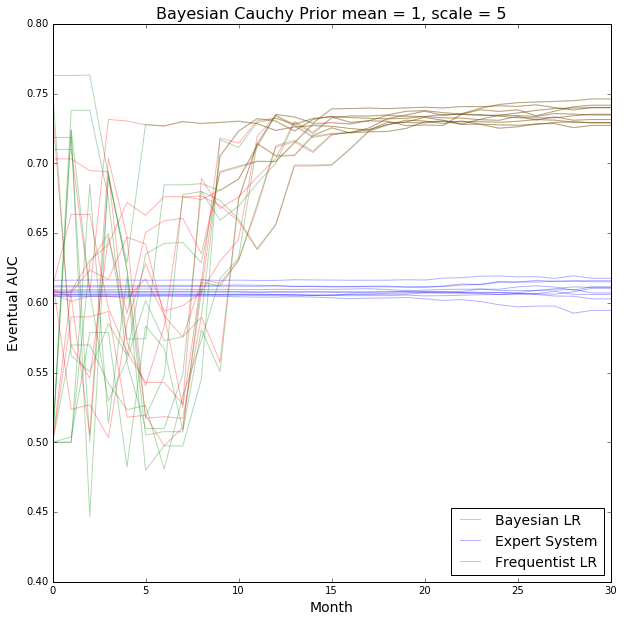

In [36]:
fig, ax = plt.subplots()
for s in range(10):
    bayes_label = None
    expert_label = None
    frequentist_label = None
    if s == 0:
        bayes_label = 'Bayesian LR'
        expert_label = 'Expert System'
        frequentist_label = 'Frequentist LR'
            
    plot(auc_3[s],color='red',alpha=0.3,label=bayes_label)
    plot(auc_expert[s],color='blue',alpha=0.3,label=expert_label)
    plot(auc_frequentist[s],color='green',alpha=0.3,label=frequentist_label)
    #plot(auc_gaussian[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)

    plt.legend(loc="lower right",fontsize=14)


    ax.set_ylabel("Eventual AUC",fontsize=14)
    ax.set_xlabel("Month",fontsize=14)
    
    plt.title('Bayesian Cauchy Prior mean = 1, scale = 5',fontsize=16)
    
    plt.gcf().set_size_inches(10, 10);

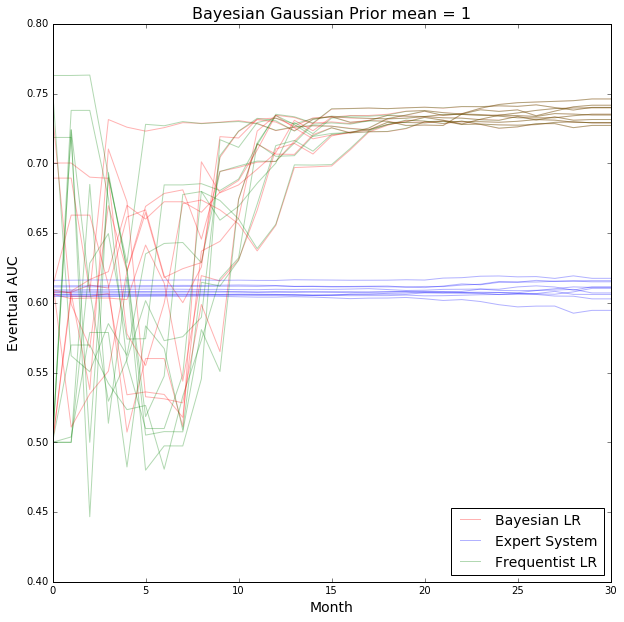

In [37]:
fig, ax = plt.subplots()
for s in range(10):
    bayes_label = None
    expert_label = None
    frequentist_label = None
    if s == 0:
        bayes_label = 'Bayesian LR'
        expert_label = 'Expert System'
        frequentist_label = 'Frequentist LR'
            
    plot(auc_gaussian[s],color='red',alpha=0.3,label=bayes_label)
    plot(auc_expert[s],color='blue',alpha=0.3,label=expert_label)
    plot(auc_frequentist[s],color='green',alpha=0.3,label=frequentist_label)
    #plot(auc_gaussian[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)
    #plot(auc_1[s],color='red',alpha=0.3,label=bayes_label)

    plt.legend(loc="lower right",fontsize=14)


    ax.set_ylabel("Eventual AUC",fontsize=14)
    ax.set_xlabel("Month",fontsize=14)
    
    plt.title('Bayesian Gaussian Prior mean = 1',fontsize=16)
    
    plt.gcf().set_size_inches(10, 10);

In [38]:
%%R
a <- data.frame(matrix(unlist(auc_1), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC1 <- rowMeans(a)
b <- data.frame(matrix(unlist(auc_2), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC2 <- rowMeans(b)
c <- data.frame(matrix(unlist(auc_3), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC3 <- rowMeans(c)
d <- data.frame(matrix(unlist(auc_expert), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC_exp <- rowMeans(d)
d <- data.frame(matrix(unlist(auc_frequentist), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC_fre <- rowMeans(d)
e <- data.frame(matrix(unlist(auc_gaussian), nrow=31, byrow=F),stringsAsFactors=FALSE)
AUC_gau <- rowMeans(e)

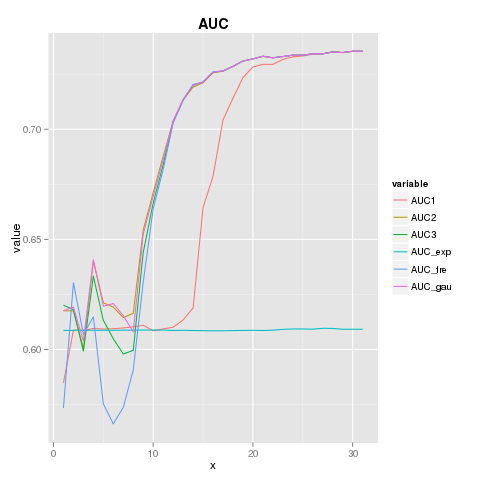

In [39]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,AUC1,AUC2,AUC3,AUC_exp,AUC_fre,AUC_gau)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

In [ ]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_1,auc_2,auc_3,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

In [ ]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_1,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

In [10]:
%%R
head(leads)
#unique(leads$MONTH)

  level_0 level_1 MONTH PURCH CUST_ID EVENTUAL_PURCH     LOG_X1         X1
0       o       0     2     0       1              0  0.2366911  1.7246110
1       o       1     4     0       2              0 -0.5199275  0.3020456
2       o       2     5     0       3              0  0.3377506  2.1764594
3       o       3     5     0       4              0  0.1991703  1.5818682
4       o       4     5     0       5              0  0.5043081  3.1938030
5       o       5     6     0       6              0  1.6379197 43.4429857
            X2          X3
0   98.0813966 152.0145585
1    0.4606934  30.8525061
2    6.1254306   9.7023990
3    9.4676814   0.6529932
4 4006.9332063   3.0918747
5    1.6418660   0.9257889


In [11]:
%%R
leads <- as.data.frame(as.matrix(leads))
leads$LOG_X1 <- as.numeric(leads$LOG_X1)
leads$X2 <- as.numeric(leads$X2)
leads$X3 <- as.numeric(leads$X3)
leads$MONTH <- as.numeric(leads$MONTH)
leads$LOG_X2 <- log10(leads$X2)
leads$LOG_X3 <- log10(leads$X3)
unique(leads$EVENTUAL_PURCH)

[1] 0 1
Levels: 0 1


In [18]:
%%R
head(leads)

  level_0 level_1 MONTH PURCH CUST_ID EVENTUAL_PURCH LOG_X1           X1   X2
0       o       0    11     0       1              0   5984 1.724611e+00 9907
1       o       1    23     0       2              0   7996 3.020456e-01 6652
2       o       2    24     0       3              0   7114 2.176459e+00 7928
3       o       3    24     0       4              0   4935 1.581868e+00 9779
4       o       4    24     0       5              0   7941 3.193803e+00 6026
5       o       5    25     0       6              0   3342 4.344299e+01 2112
    X3   LOG_X2   LOG_X3
0 1842 3.995942 3.265290
1 4827 3.822952 3.683677
2 9848 3.899164 3.993348
3 8126 3.990294 3.909877
4 4839 3.780029 3.684756
5 9653 3.324694 3.984662


In [24]:
%%R
bayesscale<- function(myVar){
  zVar <-0.5* (myVar - mean(myVar)) / sd(myVar)
  return(zVar)
}
#base
base <- leads[c('LOG_X1','LOG_X2','LOG_X3')]
base_s <- apply(base,2,bayesscale)
base_s <- data.frame(base_s)
colnames(base_s) <- c("X1s", "X2s",'X3s')
head(base_s)
leads <- cbind(leads,base_s)
head(leads)

  level_0 level_1 MONTH PURCH CUST_ID EVENTUAL_PURCH LOG_X1           X1   X2
0       o       0    11     0       1              0   5984 1.724611e+00 9907
1       o       1    23     0       2              0   7996 3.020456e-01 6652
2       o       2    24     0       3              0   7114 2.176459e+00 7928
3       o       3    24     0       4              0   4935 1.581868e+00 9779
4       o       4    24     0       5              0   7941 3.193803e+00 6026
5       o       5    25     0       6              0   3342 4.344299e+01 2112
    X3   LOG_X2   LOG_X3         X1s        X2s        X3s         X1s
0 1842 3.995942 3.265290  0.17219775  0.4963642 -0.3463161  0.17219775
1 4827 3.822952 3.683677  0.52099428  0.2966952  0.1362273  0.52099428
2 9848 3.899164 3.993348  0.36809242  0.3846602  0.4933832  0.36809242
3 8126 3.990294 3.909877 -0.00965492  0.4898455  0.3971124 -0.00965492
4 4839 3.780029 3.684756  0.51145958  0.2471523  0.1374710  0.51145958
5 9653 3.324694 3.984662 -0.

In [26]:
%%R
eva_bayes <- function(month,train,scale){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test <-  train[!msk,]
    na_msk <- is.na(local_train$PURCH)
    local_train <- local_train[!na_msk,]
    
    #if (dim(local_test)[1]==0) {
   #     auc <- 0.5
   # } 
   # else {
    model <- bayesglm(formula = PURCH ~ X1s+X2s+X3s, family = "binomial", data = local_train, 
                maxit=1000,prior.mean=1,prior.scale=scale, prior.df=1)
    predicted <- predict(model, local_test, type="response")   
    #if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
    #return 0.5 
    auc <- auc(local_test$EVENTUAL_PURCH, predicted)        
   # }    
    return(auc)    
}

In [27]:
%%R
eva_expert <- function(month,train){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test = train[!msk,]

    local_test$predicted <- local_test$X1s+local_test$X2s+local_test$X3s
    #if (model.func_name in ['freq_log_reg','gradient_boost']) and (len(local_train) == 0 or len(np.unique(local_train.PURCH)) != 2):
    #return 0.5 
    auc <- auc(local_test$EVENTUAL_PURCH, local_test$predicted)
    return(auc)    
}

In [29]:
%%R
eva_frequentist <- function(month,train){
    
    msk <- train$MONTH <= month
    msk[is.na(msk)] <- FALSE
    local_train <- train[msk,]
    local_test = train[!msk,]
    na_msk <- is.na(local_train$PURCH)
    local_train <- local_train[!na_msk,]    

    model <- glm(formula = PURCH ~ X1s+X2s+X3s, family = "binomial", data = local_train)
    predicted <- predict(model, local_test, type="response")   
    
    auc <- auc(local_test$EVENTUAL_PURCH, predicted)
    return(auc)    
}

In [30]:
%%R
auc_1 <- rep(0,31)
auc_2 <- rep(0,31)
auc_3 <- rep(0,31)
auc_expert <- rep(0,31)
auc_frequentist <- rep(0,31)
for (m in 1:31){
    auc_1[m] <- eva_bayes(m,leads,0.1)
    auc_2[m] <- eva_bayes(m,leads,2.5)
    auc_3[m] <- eva_bayes(m,leads,5)
    auc_expert[m] <- eva_expert(m,leads)
    auc_frequentist[m] <- eva_frequentist(m,leads)
}

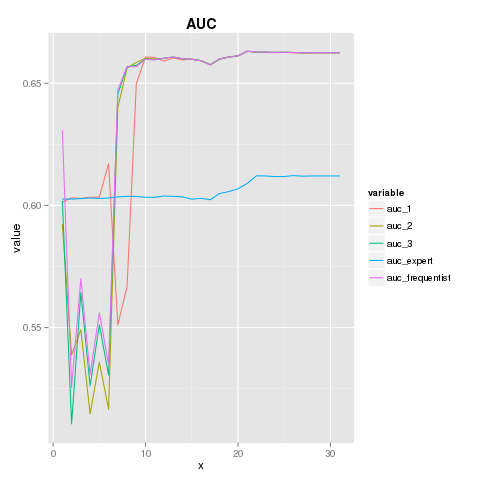

In [31]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_1,auc_2,auc_3,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

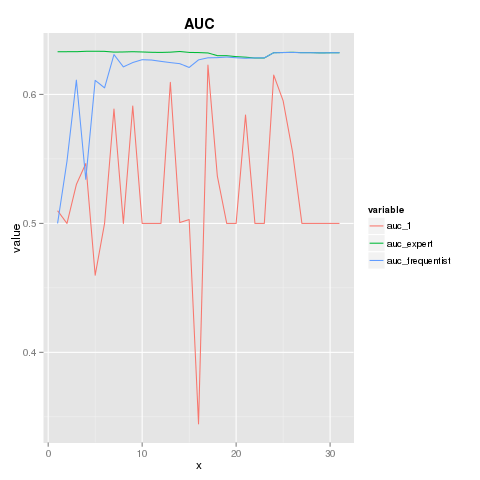

In [228]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_1,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

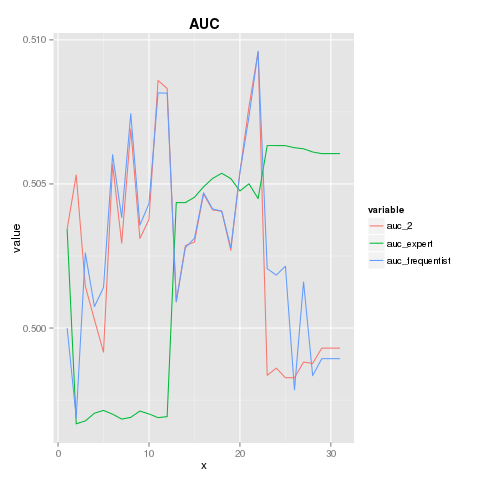

In [156]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_2,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))

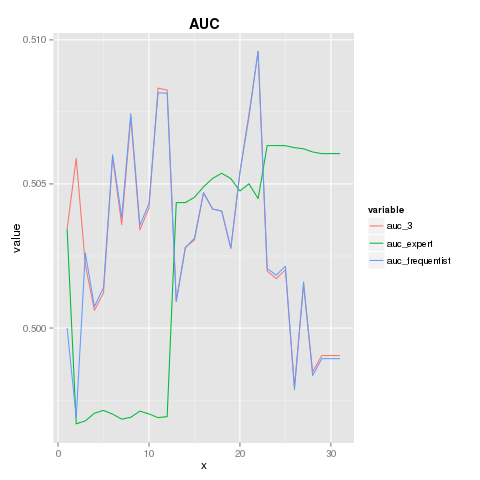

In [157]:
%%R
library(ggplot2)
library(reshape2)
# original data in a 'wide' format
x <- seq(1, 31, 1)
df1 <- data.frame(x,auc_3,auc_expert,auc_frequentist)
# melt the data to a long format
df2 <- melt(data = df1, id.vars = "x")
# plot, using the aesthetics argument 'colour'
ggplot(data = df2, aes(x = x, y = value, colour = variable),size=4) + geom_line()+
ggtitle("AUC") + theme(plot.title = element_text(lineheight=.8, face="bold"))